#**ARE 6:2:2**

In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('/content/ARE-Historical-Data.csv')
df = df.iloc[::-1]
df1=df.reset_index()['Price']


In [ ]:
df

,Date,Price,Open,High,Low,Vol.,Change %
2128,01/02/2015,89.79,89.11,89.88,88.54,277.62K,1.18%
2127,01/05/2015,90.87,89.31,91.17,89.15,359.76K,1.20%
2126,01/06/2015,91.33,90.65,91.56,90.25,1.33M,0.51%
2125,01/07/2015,92.57,91.55,92.57,90.69,543.40K,1.36%
2124,01/08/2015,93.63,92.57,93.85,92.43,718.78K,1.15%
...,...,...,...,...,...,...,...
4,06/12/2023,121.00,120.28,121.71,120.03,788.83K,0.34%
3,06/13/2023,122.06,121.15,123.93,120.50,846.11K,0.88%
2,06/14/2023,121.92,122.99,123.79,120.83,1.01M,-0.11%
1,06/15/2023,121.15,121.16,121.78,119.87,931.08K,-0.63%


In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 1s 16ms/step - loss: 0.1601 - val_loss: 0.4207
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0368 - val_loss: 0.1479
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0179 - val_loss: 0.0885
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0159 - val_loss: 0.0866
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.0805
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0666
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0094 - val_loss: 0.0538
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0076 - val_loss: 0.0438
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0348
Epoch 10/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0272
Epoch 11

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 2ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

## **Đánh giá**

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 3.2256771967884057
Testing RMSE: 3.4145274712231815
Testing MAE: 2.3468179234714386
Validation MAE: 2.5234134011661307
Testing MAPE: 1.4335188748207748
Validation MAPE: 1.5401140072157085


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):

    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.2906341]
2


## **Kết quả**

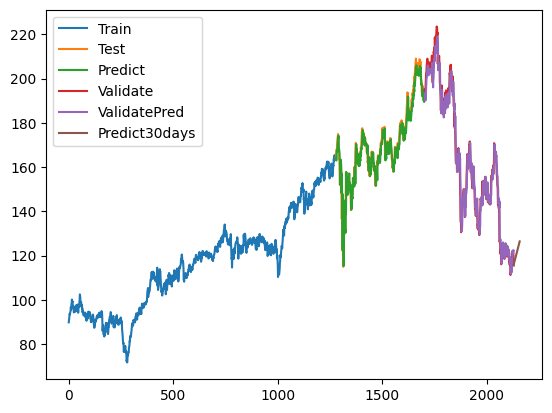

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

#**MAA 6:2:2**

In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('/content/MAA-Historical-Data.csv')
df = df.iloc[::-1]
df1=df.reset_index()['Price']


In [ ]:
df

,Date,Price,Open,High,Low,Vol.,Change %
2128,01/02/2015,76.15,74.47,76.19,74.47,276.36K,1.97%
2127,01/05/2015,75.86,75.86,76.34,75.43,549.69K,-0.38%
2126,01/06/2015,77.18,76.28,77.83,76.27,833.74K,1.74%
2125,01/07/2015,78.14,76.48,78.34,76.29,544.77K,1.24%
2124,01/08/2015,78.34,78.14,78.46,77.36,544.03K,0.26%
...,...,...,...,...,...,...,...
4,06/12/2023,152.73,153.97,153.97,151.50,489.48K,-1.00%
3,06/13/2023,153.68,151.82,153.78,151.28,513.48K,0.62%
2,06/14/2023,153.40,154.35,155.11,152.47,388.42K,-0.18%
1,06/15/2023,154.17,153.20,154.92,152.00,549.30K,0.50%


In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 2s 25ms/step - loss: 0.0270 - val_loss: 0.0887
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0481
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0059 - val_loss: 0.0522
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 0.0369
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0270
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0190
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0126
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0079
Epoch 9/100
20/20 [==============================] - 0s 8ms/step - loss: 6.1228e-04 - val_loss: 0.0047
Epoch 10/100
20/20 [==============================] - 0s 9ms/step - loss: 3.4202e-04 - val_loss: 0.0026


In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 2ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

## **Đánh giá**

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 3.1191447560913796
Testing RMSE: 2.959628596128642
Testing MAE: 2.0307305020812554
Validation MAE: 2.4089288976332717
Testing MAPE: 1.5582732326504671
Validation MAPE: 1.3398661138457537


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):

    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.52868307]
2


## **Kết quả**

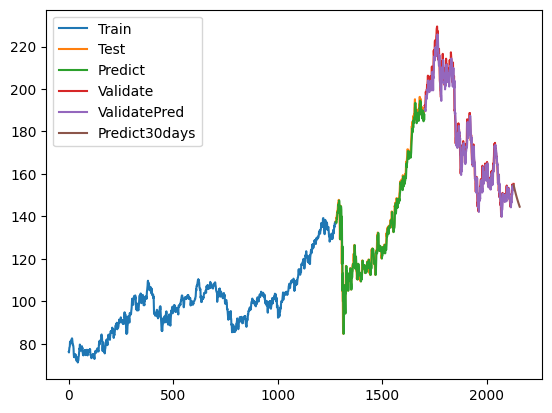

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

#**ARI 6:2:2**

In [142]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('/content/ARI-Historical-Data.csv')
df = df.iloc[::-1]
df1=df.reset_index()['Price']


In [144]:
df

,Date,Price,Open,High,Low,Vol.,Change %
2128,01/02/2015,16.54,16.49,16.55,16.35,184.56K,1.10%
2127,01/05/2015,16.51,16.47,16.63,16.45,387.43K,-0.18%
2126,01/06/2015,16.42,16.60,16.64,16.37,225.81K,-0.55%
2125,01/07/2015,16.63,16.48,16.65,16.44,492.81K,1.28%
2124,01/08/2015,16.49,16.69,16.69,16.45,440.70K,-0.84%
...,...,...,...,...,...,...,...
4,06/12/2023,11.09,10.83,11.11,10.83,754.88K,2.21%
3,06/13/2023,11.22,11.12,11.25,11.08,799.04K,1.17%
2,06/14/2023,11.19,11.27,11.38,11.09,876.19K,-0.27%
1,06/15/2023,11.42,11.15,11.44,11.14,1.07M,2.06%


In [145]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [146]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [147]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [148]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [149]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [150]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [151]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 1s 17ms/step - loss: 0.5875 - val_loss: 0.0888
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1434 - val_loss: 0.0145
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0122 - val_loss: 0.0330
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0400
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0353
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 9.9838e-04 - val_loss: 0.0336
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 9.8741e-04 - val_loss: 0.0339
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 9.8048e-04 - val_loss: 0.0339
Epoch 9/100
20/20 [==============================] - 0s 10ms/step - loss: 9.7618e-04 - val_loss: 0.0336
Epoch 10/100
20/20 [==============================] - 0s 7ms/step - loss: 9.7304e-04 - val_

In [152]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 2ms/step


In [153]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

## **Đánh giá**

In [154]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 1.2118638221644107
Testing RMSE: 1.3017351617016077
Testing MAE: 1.107366021970203
Validation MAE: 1.1484863552317894
Testing MAPE: 11.347153528180955
Validation MAPE: 10.213740955349396


In [162]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):

    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.5395724]
2


## **Kết quả**

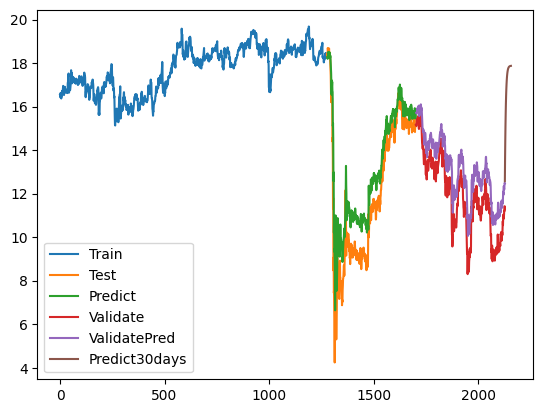

In [160]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()